In [1]:
import xarray
import numpy as np
import metpy 
from cartopy import crs as ccrs
import matplotlib as M
import matplotlib.pyplot as plt 

from herbie import Herbie
H = Herbie(
    "2023-11-07 18:00",
    model="hrrr",
    product="nat",
    fxx=1,
)
q_t2m = ":TMP:2 m"
ds_t2m = H.xarray(q_t2m)
variables = [i for i in list(ds_t2m) if len(ds_t2m[i].dims) > 0]
ds_t2m = ds_t2m.metpy.parse_cf(varname=variables).squeeze().metpy.assign_y_x()

ds_t2m

✅ Found ┊ model=hrrr ┊ product=nat ┊ 2023-Nov-07 18:00 UTC F01 ┊ GRIB2 @ aws ┊ IDX @ aws


/var/folders/rr/m6rsyqmd64q6ddlcqfq1sng00000gp/T/ipykernel_22363/2255406080.py:18: UserWarning: More than one time coordinate present for variable  "t2m".
  ds_t2m = ds_t2m.metpy.parse_cf(varname=variables).squeeze().metpy.assign_y_x()


<xarray.Dataset>
Dimensions:            (y: 1059, x: 1799)
Coordinates:
    time               datetime64[ns] 2023-11-07T18:00:00
    step               timedelta64[ns] 01:00:00
    heightAboveGround  float64 2.0
    latitude           (y, x) float64 21.14 21.15 21.15 ... 47.86 47.85 47.84
    longitude          (y, x) float64 237.3 237.3 237.3 ... 299.0 299.0 299.1
    valid_time         datetime64[ns] 2023-11-07T19:00:00
    metpy_crs          object Projection: lambert_conformal_conic
  * y                  (y) float64 -1.587e+06 -1.584e+06 ... 1.584e+06 1.587e+06
  * x                  (x) float64 -2.698e+06 -2.695e+06 ... 2.693e+06 2.696e+06
Data variables:
    t2m                (y, x) float32 295.3 295.3 295.3 ... 280.1 280.1 280.1
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    model:                   hrrr
    product:                 nat
    description:             High-Resolution Rapid Refresh - CONUS
    remote_grib:             https://noaa-hrrr-bdp-pds.s3.amazonaws.com/hrrr....
    local_grib:              /Users/johnlawson/data/hrrr/20231107/subset_1de4...
    searchString:            :TMP:2 m

In [3]:
# Get lat/lon nearest neighbour
def get_closest_point(ds,vrbl,lat,lon):
    grid_crs = ds[vrbl].metpy.cartopy_crs
    latlon_crs = ccrs.PlateCarree(globe=ds[vrbl].metpy.cartopy_globe)
    x_t, y_t = grid_crs.transform_point(lon, lat, src_crs=latlon_crs)
    return ds[vrbl].sel(x=x_t,y=y_t,method="nearest")

# Vernal
lon, lat = (360-109.5287, 40.4555)
x = get_closest_point(ds_t2m,"t2m",lat,lon)
print(x)

<xarray.DataArray 't2m' ()>
array(284.4496, dtype=float32)
Coordinates:
    time               datetime64[ns] 2023-11-07T18:00:00
    step               timedelta64[ns] 01:00:00
    heightAboveGround  float64 2.0
    latitude           float64 40.46
    longitude          float64 250.5
    valid_time         datetime64[ns] 2023-11-07T19:00:00
    metpy_crs          object Projection: lambert_conformal_conic
    y                  float64 2.847e+05
    x                  float64 -1.015e+06
Attributes: (12/37)
    GRIB_paramId:                             167
    GRIB_dataType:                            fc
    GRIB_numberOfPoints:                      1905141
    GRIB_typeOfLevel:                         heightAboveGround
    GRIB_stepUnits:                           1
    GRIB_stepType:                            instant
    ...                                       ...
    GRIB_stepRange:                           1
    GRIB_units:                               K
    long_name:       

In [4]:
# ds_t2m.to_netcdf('test.nc')

In [5]:
#print("Crop lat/lons")
# my_extent = [-110.6,-108.7,41.05,39.65]
ds_t2m = ds_t2m.rename({'x':'west_east','y':'south_north'})

# sw_corner = (39.6, 360-110.6)
# ne_corner = (41.05, 360-108.7)
sw_corner = (39.4, -110.9)
ne_corner = (41.1, -108.5)
# ds_t2m = ds_t2m.rename({'x':'west_east','y':'south_north'})
lats = ds_t2m.latitude.values
lons = ds_t2m.longitude.values

if np.max(lons) > 180.0: 
    lons -= 360.0

# if np.max(lons) > 180.0: lons = lons - 360.0
crop = xarray.DataArray(np.logical_and(np.logical_and(lats>sw_corner[0],
                     lats<ne_corner[0]),np.logical_and(lons>sw_corner[1],lons<ne_corner[1])),
                    dims=['south_north','west_east'])
                        # dims = ["y","x"])
ds_out = ds_t2m.where(crop,drop=True)
ds_out

<xarray.Dataset>
Dimensions:            (south_north: 71, west_east: 76)
Coordinates:
    time               datetime64[ns] 2023-11-07T18:00:00
    step               timedelta64[ns] 01:00:00
    heightAboveGround  float64 2.0
    latitude           (south_north, west_east) float64 39.18 39.18 ... 41.32
    longitude          (south_north, west_east) float64 -110.8 -110.8 ... -108.5
    valid_time         datetime64[ns] 2023-11-07T19:00:00
    metpy_crs          object Projection: lambert_conformal_conic
  * south_north        (south_north) float64 1.587e+05 1.617e+05 ... 3.687e+05
  * west_east          (west_east) float64 -1.147e+06 -1.144e+06 ... -9.215e+05
Data variables:
    t2m                (south_north, west_east) float32 nan nan nan ... nan nan
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    model:                   hrrr
    product:                 nat
    description:             High-Resolution Rapid Refresh - CONUS
    remote_grib:             https://noaa-hrrr-bdp-pds.s3.amazonaws.com/hrrr....
    local_grib:              /Users/johnlawson/data/hrrr/20231107/subset_1de4...
    searchString:            :TMP:2 m

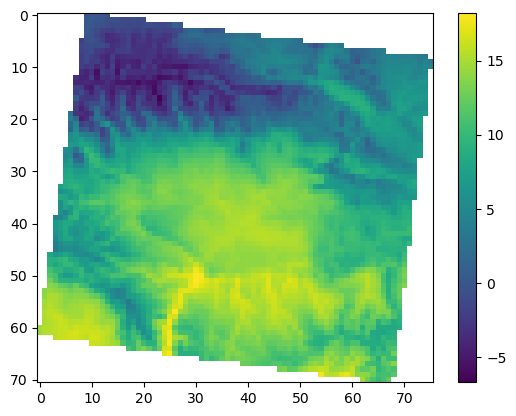

In [6]:
t2m_C = ds_out.t2m - 273.15
fig,ax = plt.subplots(1)
im = ax.imshow(t2m_C[::-1,:])
plt.colorbar(im)

In [13]:
## Now do temperature, height, model sounding
q_Z = ':HGT:.*hybrid'
ds_Z = H.xarray(q_Z)
ds_Z

<xarray.Dataset>
Dimensions:              (hybrid: 50, y: 1059, x: 1799)
Coordinates:
    time                 datetime64[ns] 2023-11-07T18:00:00
    step                 timedelta64[ns] 01:00:00
  * hybrid               (hybrid) float64 1.0 2.0 3.0 4.0 ... 48.0 49.0 50.0
    latitude             (y, x) float64 21.14 21.15 21.15 ... 47.86 47.85 47.84
    longitude            (y, x) float64 237.3 237.3 237.3 ... 299.0 299.0 299.1
    valid_time           datetime64[ns] 2023-11-07T19:00:00
Dimensions without coordinates: y, x
Data variables:
    gh                   (hybrid, y, x) float32 10.79 10.79 ... 2.707e+04
    gribfile_projection  object None
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    model:                   hrrr
    product:                 nat
    description:             High-Resolution Rapid Refresh - CONUS
    remote_grib:             https://noaa-hrrr-bdp-pds.s3.amazonaws.com/hrrr....
    local_grib:              /Users/johnlawson/data/hrrr/20231107/subset_1de4...
    searchString:            :HGT:.*hybrid

In [14]:
variables = [i for i in list(ds_Z) if len(ds_Z[i].dims) > 0]
ds_Z2 = ds_Z.metpy.parse_cf(varname=variables).squeeze().metpy.assign_y_x()

/var/folders/rr/m6rsyqmd64q6ddlcqfq1sng00000gp/T/ipykernel_22363/3024678612.py:2: UserWarning: More than one time coordinate present for variable  "gh".
  ds_Z2 = ds_Z.metpy.parse_cf(varname=variables).squeeze().metpy.assign_y_x()


In [15]:
xy = get_closest_point(ds_Z2,"gh",lat,lon)
if np.max(lons) > 180.0: 
    lons -= 360.0

crop = xarray.DataArray(np.logical_and(np.logical_and(lats>sw_corner[0],
                     lats<ne_corner[0]),np.logical_and(lons>sw_corner[1],lons<ne_corner[1])),
                    # dims=['south_north','west_east'])
                        dims = ["y","x"])
ds_out = ds_Z2.where(crop,drop=True)
ds_out

<xarray.Dataset>
Dimensions:     (hybrid: 50, y: 71, x: 76)
Coordinates:
    time        datetime64[ns] 2023-11-07T18:00:00
    step        timedelta64[ns] 01:00:00
  * hybrid      (hybrid) float64 1.0 2.0 3.0 4.0 5.0 ... 47.0 48.0 49.0 50.0
    latitude    (y, x) float64 39.18 39.18 39.19 39.19 ... 41.31 41.31 41.32
    longitude   (y, x) float64 249.2 249.2 249.2 249.3 ... 251.4 251.4 251.5
    valid_time  datetime64[ns] 2023-11-07T19:00:00
    metpy_crs   object Projection: lambert_conformal_conic
  * y           (y) float64 1.587e+05 1.617e+05 ... 3.657e+05 3.687e+05
  * x           (x) float64 -1.147e+06 -1.144e+06 ... -9.245e+05 -9.215e+05
Data variables:
    gh          (hybrid, y, x) float32 nan nan nan nan nan ... nan nan nan nan
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    model:                   hrrr
    product:                 nat
    description:             High-Resolution Rapid Refresh - CONUS
    remote_grib:             https://noaa-hrrr-bdp-pds.s3.amazonaws.com/hrrr....
    local_grib:              /Users/johnlawson/data/hrrr/20231107/subset_1de4...
    searchString:            :HGT:.*hybrid

In [17]:
q_tmp = ":TMP:.*hybrid"
ds_tmp = H.xarray(q_tmp)
ds_tmpfig,ax = plt.subplots(1)
im = ax.imshow(t2m_C[::-1,:])
plt.colorbar(im)

<xarray.Dataset>
Dimensions:              (hybrid: 50, y: 1059, x: 1799)
Coordinates:
    time                 datetime64[ns] 2023-11-07T18:00:00
    step                 timedelta64[ns] 01:00:00
  * hybrid               (hybrid) float64 1.0 2.0 3.0 4.0 ... 48.0 49.0 50.0
    latitude             (y, x) float64 21.14 21.15 21.15 ... 47.86 47.85 47.84
    longitude            (y, x) float64 237.3 237.3 237.3 ... 299.0 299.0 299.1
    valid_time           datetime64[ns] 2023-11-07T19:00:00
Dimensions without coordinates: y, x
Data variables:
    t                    (hybrid, y, x) float32 295.2 295.2 ... 215.8 215.8
    gribfile_projection  object None
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    model:                   hrrr
    product:                 nat
    description:             High-Resolution Rapid Refresh - CONUS
    remote_grib:             https://noaa-hrrr-bdp-pds.s3.amazonaws.com/hrrr....
    local_grib:              /Users/johnlawson/data/hrrr/20231107/subset_1de4...
    searchString:            :TMP:.*hybrid

ValueError: Unsupported key-type <class 'tuple'>

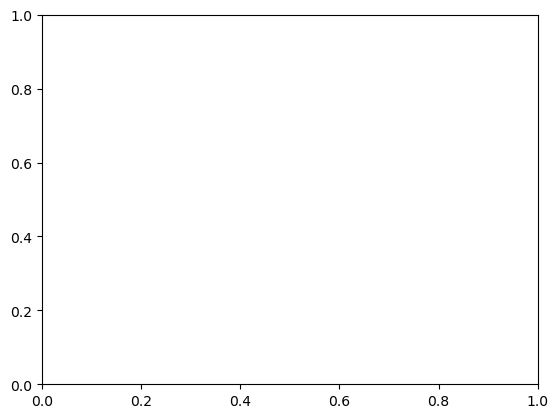

In [18]:
fig,ax = plt.subplots(1)
im = ax.imshow(ds_out[0,::-1,:])
plt.colorbar(im)